<a href="https://colab.research.google.com/github/GabeMaldonado/JupyterNotebooks/blob/master/Prophet_Evaluation_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from fbprophet import Prophet
%matplotlib inline

 ## Load Data
 
 Analize Miles_Traveled dataset.

In [0]:
df = pd.read_csv('Miles_Traveled.csv')

In [19]:
df.head()

,DATE,TRFVOLUSM227NFWA
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
DATE                588 non-null object
TRFVOLUSM227NFWA    588 non-null float64
dtypes: float64(1), object(1)
memory usage: 9.3+ KB


In [21]:
df.describe()

,TRFVOLUSM227NFWA
count,588.000000
mean,190420.380952
std,57795.538934
min,77442.000000
25%,133579.000000
50%,196797.500000
75%,243211.500000
max,288145.000000


Change columns names to Prophet specs and change the data column to a timeseries object.

In [22]:
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
ds    588 non-null datetime64[ns]
y     588 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.3 KB


## Visualize Data

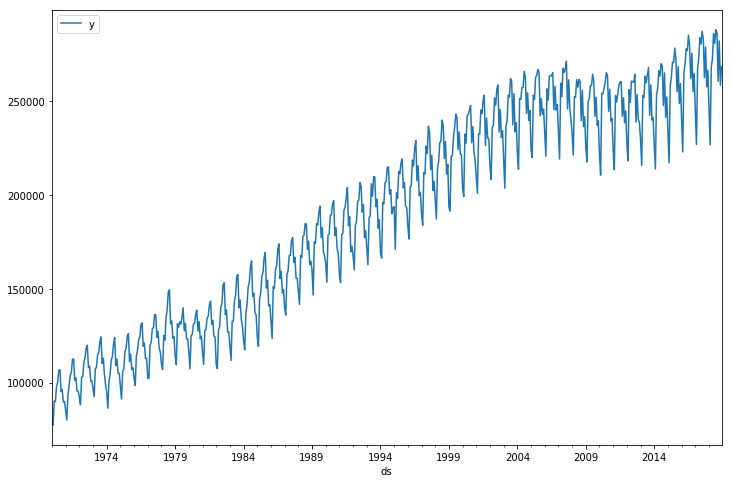

In [27]:
pd.plotting.register_matplotlib_converters()
df.plot(x='ds', y='y', figsize = (12,8));

## Run Prophet on Test set and run Evaluations.

In [28]:
len(df)

588

In [0]:
# Create training set

train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [35]:
# Create Prophet instance

m = Prophet()

# fit model

m.fit(train)

# create a placeholder for future predictions

future = m.make_future_dataframe(periods=12, freq='MS')

# get forecast on future df

forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
# print forecast tail

forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
583,2018-08-01,263410.800604,273946.550023,285503.932507,263343.077564,263477.133709,16448.013049,16448.013049,16448.013049,16448.013049,16448.013049,16448.013049,0.0,0.0,0.0,279858.813654
584,2018-09-01,263552.915940,256365.077279,267835.455188,263447.397126,263648.573373,-1670.418537,-1670.418537,-1670.418537,-1670.418537,-1670.418537,-1670.418537,0.0,0.0,0.0,261882.497404
585,2018-10-01,263690.446911,262760.269741,274866.907060,263542.899517,263810.852602,5305.505873,5305.505873,5305.505873,5305.505873,5305.505873,5305.505873,0.0,0.0,0.0,268995.952784
586,2018-11-01,263832.562247,249921.672602,261436.555424,263658.943503,263978.577730,-8208.986942,-8208.986942,-8208.986942,-8208.986942,-8208.986942,-8208.986942,0.0,0.0,0.0,255623.575305
587,2018-12-01,263970.093217,251560.897604,263186.227119,263746.322784,264156.491737,-6922.716937,-6922.716937,-6922.716937,-6922.716937,-6922.716937,-6922.716937,0.0,0.0,0.0,257047.376280


## Plot Predicted Values over True Values

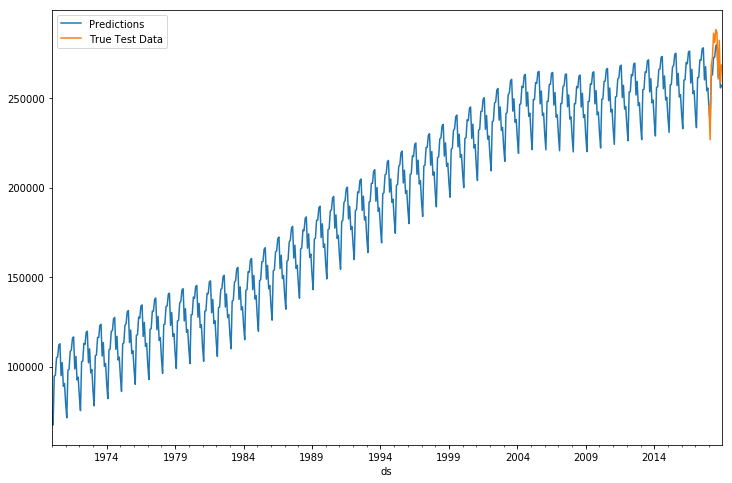

In [44]:
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label='True Test Data', legend=True, ax=ax);   #ax connects the two graphs to same axis.

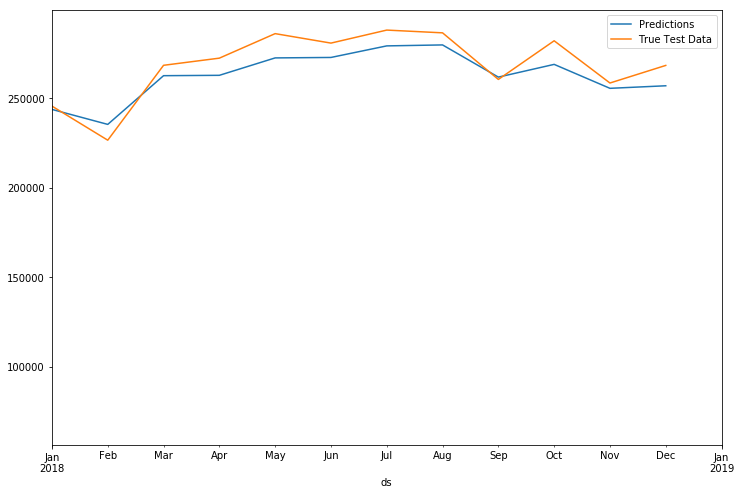

In [45]:
# Zoom into the forecast
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label='True Test Data', legend=True, ax=ax, xlim=('2018-01-01', '2019-01-01')); 

## Evaluate Predictions Using Statsmodels Root Mean Squared Error (MSE)

In [0]:
from statsmodels.tools.eval_measures import rmse

In [49]:
# get predictions

predictions = forecast.iloc[-12:]['yhat']
predictions

576    243850.453937
577    235480.588794
578    262683.274392
579    262886.236399
580    272609.522601
581    272862.615300
582    279321.841101
583    279858.813654
584    261882.497404
585    268995.952784
586    255623.575305
587    257047.376280
Name: yhat, dtype: float64

In [50]:
# compare to test set
test['y']

576    245695.0
577    226660.0
578    268480.0
579    272475.0
580    286164.0
581    280877.0
582    288145.0
583    286608.0
584    260595.0
585    282174.0
586    258590.0
587    268413.0
Name: y, dtype: float64

In [53]:
# calculate rmse

rmse(predictions, test['y'])

8618.783155559411

In [54]:
test.mean()

y    268739.666667
dtype: float64

## Evaluate Predictions Using Prophet's Evaluation Tools

Prophet has it own evaluations tools that allows us to perform *cross-validation* in different sections of the dataset instead of the last section as we saw above. 
When performing cross-validation, there are 3 things that need to be defined:


*   Initial training period
*   Period lenght to perform validation
*   Horizon of prediction



In [0]:
## import prophet eval tools

from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [56]:
# Define:

# Initial -- period is 5 years

initial = 5 * 365
initial = str(initial) + ' days'
initial

'1825 days'

In [57]:
# Define:

# Period

period = 5 * 365
period = str(period) + ' days'
period

'1825 days'

In [0]:
# Define:

# Horizon -- one year ahead

horizon = 365
horizon = str(horizon) + ' days'


In [59]:
# perform cross-validation -- args: model, initial, period, horizon

df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)

INFO:fbprophet:Making 9 forecasts with cutoffs between 1976-12-11 00:00:00 and 2016-12-01 00:00:00


In [60]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1977-01-01,108479.087306,106990.603148,109837.430105,102445.0,1976-12-11
1,1977-02-01,102996.111502,101607.192966,104416.448231,102416.0,1976-12-11
2,1977-03-01,118973.317944,117460.910009,120468.316343,119960.0,1976-12-11
3,1977-04-01,120612.923539,119182.220594,122067.307008,121513.0,1976-12-11
4,1977-05-01,127883.031663,126442.196287,129351.375440,128884.0,1976-12-11


In [61]:
# Get data from cv
# mae --> mean absolute error
#mape --> mean absolute percent error

performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,52 days,2.402227e+07,4901.251892,4506.384371,0.027631,0.4
1,53 days,2.150811e+07,4637.683407,4238.662732,0.024863,0.4
2,54 days,1.807689e+07,4251.692535,3708.943275,0.019933,0.5
3,55 days,2.298205e+07,4793.960154,4236.275244,0.023042,0.4
4,57 days,2.078937e+07,4559.535784,3972.087270,0.021317,0.5
5,58 days,2.306545e+07,4802.649969,4248.916338,0.022521,0.4
6,59 days,3.794246e+07,6159.745363,5069.232548,0.026221,0.4
7,60 days,3.875108e+07,6225.036249,5136.940670,0.026702,0.4
8,62 days,3.722136e+07,6100.930821,4941.278113,0.025845,0.4
9,80 days,3.260728e+07,5710.278221,4353.547479,0.023861,0.5


## Plot  Cross Validation Metrics

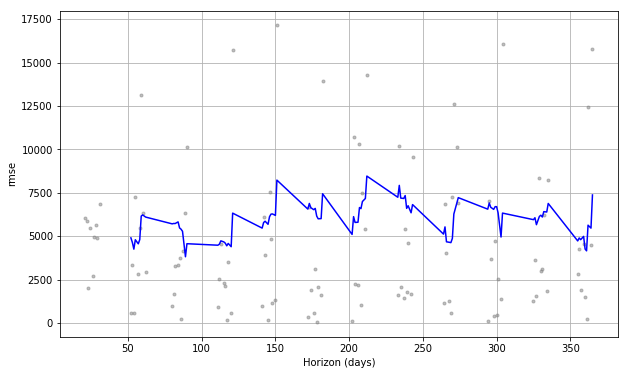

In [64]:
# plot rmse
plot_cross_validation_metric(df_cv, metric='rmse');

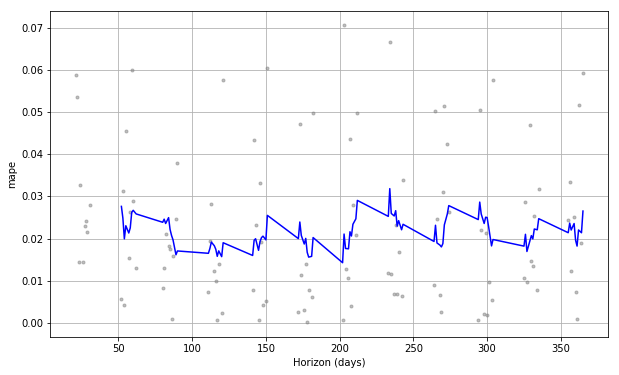

In [65]:
# plot mape
plot_cross_validation_metric(df_cv, metric='mape');